# Import Libraries

In [34]:
import time
import random
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [35]:
torch.cuda.is_available()

False

# Load Data

In [36]:
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

# Data 구성
- 본 문제의 목표는 기존의 MNIST와 다르게,
- **문자 속에 숨어있는 숫자를 예측**하는 것.

In [37]:
train.set_index('id').head()

,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


In [38]:
train.shape

(2048, 787)

- train은 digit, letter, 0~783(pixels)의 총 786개의 column과 2,048개의 instance로 구성

In [39]:
test.set_index('id').head()

,letter,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,...,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,...,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,...,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,...,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,...,4,3,1,4,0,2,1,2,3,4


In [40]:
test.shape

(20480, 786)

- test은 letter, 0~783(pixels)의 총 785개의 column과 2,048개의 instance로 구성
- `digit`이 우리가 예측하고자 하는 target variable

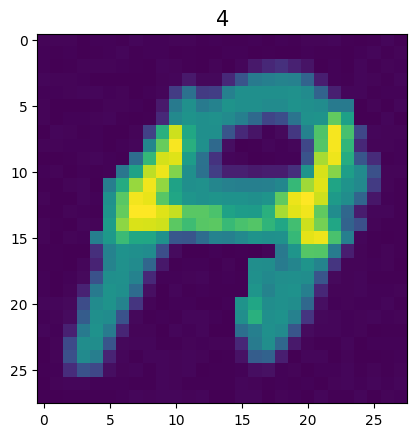

In [41]:
img = train.query("letter == 'A'")[
    [(str(i)) for i in range(784)]
].iloc[28].values.reshape(28, 28)
plt.imshow(img)
plt.title(train.query("letter == 'A'").iloc[28]['digit'], fontsize=15)
plt.show()

In [42]:
train.query("letter == 'A'").iloc[28].iloc[:3]

id        774
digit       4
letter      A
Name: 773, dtype: object

- 위의 이미지는 `A` 문자 속에 `4`가 숨이있다!
- 모든 이미지들은 위와 같이 생겼음.
- 4를 예측하는 것이 우리의 목표.

### CNN을 사용해보자!
- CNN은 영상 처리 기법을 DEEP LEARNING으로 구현한 것(이라고 저는 이해)
- 아래 커널을 이미지마다 적용, Convolution 연산(가중합)을 취해 이미지의 특성을 파악하는 것이 목적

In [43]:
from scipy.signal import correlate2d

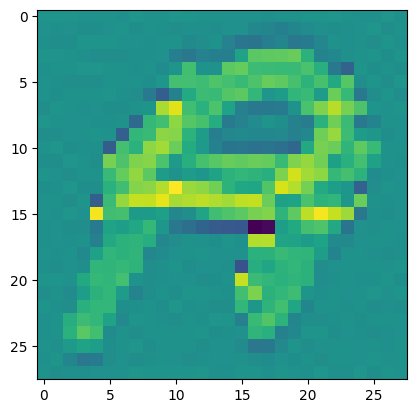

In [44]:
# 이런 식으로 특성을 파악하는 것이 목적이다.

kernel = np.array(
    [
        [0, -100, 0],
        [0, 255, 0],
        [0, -100, 0],
    ]
)
plt.imshow(correlate2d(img, kernel, mode='same'))

# Baseline 구축

- `LightGBM`
- `PyTorch - CNN`
- `Keras - CNN`

## 1. LightGBM

In [45]:
# 문자 데이터를 one-hot encoding하고
# 이미지 픽셀 데이터를 784개의 위치 feature라고 생각하고 concat
X_train = pd.concat(
    (pd.get_dummies(train.letter), train[[str(i) for i in range(784)]]), 
    axis=1)
y_train = train['digit']

In [46]:
X_train.head()

,A,B,C,D,E,F,G,H,I,J,...,774,775,776,777,778,779,780,781,782,783
0,False,False,False,False,False,False,False,False,False,False,...,2,1,0,1,2,4,4,4,3,4
1,False,True,False,False,False,False,False,False,False,False,...,0,3,0,1,4,1,4,2,1,2
2,False,False,False,False,False,False,False,False,False,False,...,3,3,3,0,2,0,3,0,2,2
3,False,False,False,True,False,False,False,False,False,False,...,3,3,2,0,1,4,0,0,1,1
4,True,False,False,False,False,False,False,False,False,False,...,4,4,3,2,1,3,4,3,1,2


In [47]:
y_train

0       5
1       0
2       4
3       9
4       6
       ..
2043    6
2044    1
2045    9
2046    0
2047    5
Name: digit, Length: 2048, dtype: int64

In [48]:
# Train set을 8:2로 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [49]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(device='gpu') # GPU를 쓰려면 따로 설치해줘야 함.
# http://www.kwangsiklee.com/2018/05/lightgbm-사용시-gpu-가속하기/
# 위의 링크 참고할 것.

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
# 모델 적합
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
# 예측 정확도 출력
print((lgb.predict(X_valid) == y_valid.values).sum() / len(y_valid))

0.5536585365853659


In [ ]:
# Test 데이터에 대해 예측을 진행
X_test = pd.concat(
    (pd.get_dummies(test.letter), test[[str(i) for i in range(784)]]), 
axis=1)

# Submission 컬럼에 이를 기록
submission.digit = lgb.predict(X_test)

# 파일로 저장 후 업로드
submission.to_csv('first_submission.csv', index=False) # 57.84313725% 의 결과를 얻음

## 2. PyTorch - CNN
- 입력 이미지의 shape을 `(batch_size, n_channels, width, height)`로 넣어줘야 함.

In [ ]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

In [ ]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [ ]:
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)


# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)
validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Model Construct

class ConvClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding=1), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding=2), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.ReLU(),
        )
        
        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding=2), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding=3), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding=3), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding=3), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding=3), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding=3), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding=3), nn.ReLU(),
        )
        
        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out
    
    def _inference(self, x1, x2):
        bsz = x1.size(0)
        
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        
        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)
        
        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)
        
        return out

In [ ]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [ ]:
# 입력이 제대로 들어갈 지 확인
x1 = X_train[:32, :, :26].cuda()
x2 = X_train[:32, :, 26:].reshape(-1, 1, 28, 28).cuda()

model(x1, x2).shape

torch.Size([32, 10])

In [ ]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr=2e-5, # 학습률
    eps=1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 150

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda")

In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행                
        outputs = model(x1, x2, label)
        
        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())
        
        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
        
    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(x1, x2, label)
        
        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 150/150] Avg Training Loss: 1.54 Valid Acc: 0.69
Training complete!


In [ ]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'convclf200803.pt')

In [ ]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('convclf200803.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [ ]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

In [ ]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv('second_submission.csv', index=False) # 0.6960784314%

## 3. Keras - CNN
- 입력 이미지의 shape을 `(batch_size, width, height, n_channels)`로 넣어줘야 함.
- Keras 모델과 Torch 모델을 한 노트북에서 돌릴 경우, GPU할당 문제로 오류가 뜸.
- 아래 코드를 다른 노트북에 옮겨서 새롭게 라이브러리, 데이터를 호출 후 진행 바람.

In [ ]:
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)

# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# How to check if Keras is using GPU?

from keras import backend as K

K.tensorflow_backend._get_available_gpus()

train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

Using TensorFlow backend.


In [ ]:
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(train['digit'].values)

In [ ]:
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          1

In [ ]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [ ]:
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train, y_train, test_size = 0.1)

history = model.fit_generator(
    datagen.flow(X_train2, y_train2, batch_size=32),
    epochs=epochs, 
    steps_per_epoch=X_train2.shape[0]//32,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer], 
    verbose=0
)
print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['acc']):.5f}, " +
    f"Validation accuracy={max(history.history['val_acc']):.5f}"
)

CNN: Epochs=45, Train accuracy=0.78355, Validation accuracy=0.78049


In [ ]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"model.json", "w") as json_file : 
    json_file.write(model_json)

In [ ]:
# 예측 진행
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
results = model.predict(X_test)

In [ ]:
submission.digit = results
submission.to_csv('1234.csv', index=False) # 0.795575446%

# 결론
- 여러 아이디어가 있었으나, 일단 딥러닝은 깊게 쌓고 많이 돌려봐야 과적합인지 과소적합인지가 나오는 듯.
- 많이 쌓고 연산 돌려봅시다.
- 구조에 대한 이해도가 필요할 듯
- 의외로 LeakyReLU냐 그냥 ReLU냐에 따른 성능 차이도 존재
- skip-connection 등 여러 개념을 적용하며 성능을 높여보자!
- letter의 정보를 적극적으로 활용할 방안이 있을까?
- 어지간하면 keras쓰자. torch로 짜기엔 너무 할게 많...
- 그리고 성능도 keras가 우리같은 입문자에겐 더 좋다. 이미 성능이 좋기로 알려진 초기화 기법들, 과적합 방지 기술들이 잘 구현되어 있다!!
- Learning Rate 조절도 신경써서 해보자!